In [4]:
import numpy as np
from sklearn import metrics

import nbfuns
import importlib
importlib.reload(nbfuns)
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.callbacks import ModelCheckpoint, EarlyStopping

from experiments.models import model_purchase100
import experiments.data_utils

from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack import data_structures
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack import membership_inference_attack as mia
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack import plotting
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack import privacy_report

from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import AttackInputData
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import SlicingSpec
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import AttackType
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import AttackResults

In [5]:
attacks_result = AttackResults.load("./pickles/attack_results_purchase100.p")

Best-performing attacks over all slices
  THRESHOLD_ATTACK (with 12 training and 16 test examples) achieved an AUC of 0.90 on slice CLASS=29
  THRESHOLD_ATTACK (with 12 training and 16 test examples) achieved an advantage of 0.81 on slice CLASS=29

Best-performing attacks over slice: "Entire dataset"
  RANDOM_FOREST (with 24665 training and 24665 test examples) achieved an AUC of 0.68
  RANDOM_FOREST (with 24665 training and 24665 test examples) achieved an advantage of 0.31

Best-performing attacks over slice: "CLASS=0"
  RANDOM_FOREST (with 177 training and 177 test examples) achieved an AUC of 0.65
  RANDOM_FOREST (with 177 training and 177 test examples) achieved an advantage of 0.29

Best-performing attacks over slice: "CLASS=1"
  K_NEAREST_NEIGHBORS (with 101 training and 101 test examples) achieved an AUC of 0.74
  RANDOM_FOREST (with 101 training and 101 test examples) achieved an advantage of 0.46

Best-performing attacks over slice: "CLASS=2"
  RANDOM_FOREST (with 574 trainin

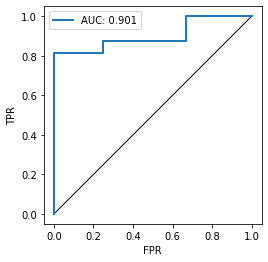

In [6]:
# Plot the ROC curve of the best classifier
fig = plotting.plot_roc_curve(
    attacks_result.get_result_with_max_auc().roc_curve)

# Print a user-friendly summary of the attacks
print(attacks_result.summary(by_slices = True))

Best-performing attacks over all slices
  THRESHOLD_ATTACK (with 12 training and 16 test examples) achieved an AUC of 0.90 on slice CLASS=29
  THRESHOLD_ATTACK (with 12 training and 16 test examples) achieved an advantage of 0.81 on slice CLASS=29


slice feature slice value  train size  test size          attack type  \
5           class           0         177        177  K_NEAREST_NEIGHBORS   
8           class           1         101        101  K_NEAREST_NEIGHBORS   
11          class           2         574        574  K_NEAREST_NEIGHBORS   
14          class           3         129        129  K_NEAREST_NEIGHBORS   
17          class           4         306        306  K_NEAREST_NEIGHBORS   
..            ...         ...         ...        ...                  ...   
290         class          95         101        101  K_NEAREST_NEIGHBORS   
293         class          96         122        122  K_NEAREST_NEIGHBORS   
296         class          97         293        293  K_NEAREST_NEIGHBORS   
299         class          98         238        238  K_NEAREST_NEIGHBORS   
302         class          99         200        200  K_NEAREST_NEIGHBORS   

     Attacker advantage       AUC  
5              0.177273  0.571970  
8              0.332308  0.736923  
11             0.182984  0.630730  
14             0.289773  0.706439  
17             0.290670  0.650803  
..                  ...       ...  
290            0.384615  0.706923  
293            0.450538  0.705376  
296            0.337468  0.667068  
299            0.209040  0.627119  
302            0.440000  0.765600  

[100 rows x 7 columns]

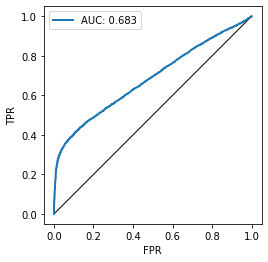

In [7]:
res_df = attacks_result.calculate_pd_dataframe()
print(attacks_result.summary(by_slices = False))

fig = plotting.plot_roc_curve(
    attacks_result.single_attack_results[1].roc_curve)

attack_types = [AttackType.THRESHOLD_ATTACK,
                AttackType.RANDOM_FOREST,
                AttackType.K_NEAREST_NEIGHBORS]

res_df.drop(res_df[res_df["slice feature"] == "Entire dataset"].index, inplace=True)
res_df.drop(res_df[res_df["slice feature"] == "correctly_classified"].index, inplace=True)

res_ta = res_df.loc[res_df['attack type'] == "THRESHOLD_ATTACK"]
res_rf = res_df.loc[res_df['attack type'] == "RANDOM_FOREST"]
res_knn = res_df.loc[res_df['attack type'] == "K_NEAREST_NEIGHBORS"]

res_knn

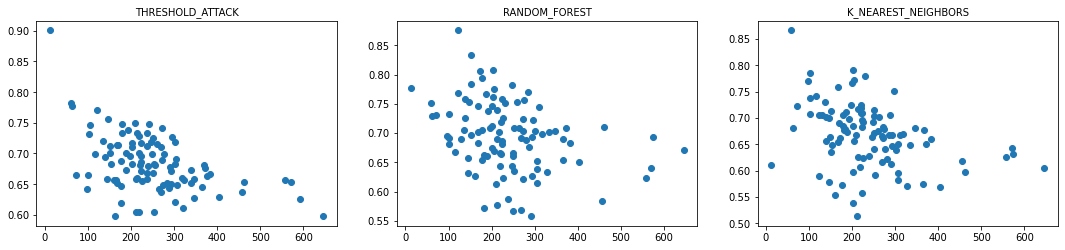

In [8]:
fsize = (nbfuns._DEFAULT_FIGSIZE[0] * 3, nbfuns._DEFAULT_FIGSIZE[1])
fig, ax = plt.subplots(1, 3, figsize=fsize)
for i, atk_type in enumerate(attack_types):
    res = res_df.loc[res_df['attack type'] == str(atk_type)]
    ax[i].scatter(res["train size"], res["AUC"])
    ax[i].set_title(str(atk_type), fontsize="medium")
    #res.plot(
    #   x="train size",
    #    y=["AUC"],
    #    kind="scatter",
    #    layout=(1,2),
    #    xlabel="Class index",
    #    title="AUC: " + str(atk_type),
    #    )
#fig.suptitle('Purchase100 Large NN: Results Per Slices', fontsize="large")
#fig.subplots_adjust(top=0.88)
plt.savefig("./img/purchase100-atk-types/purchase100.pdf", bbox_inches='tight')

In [15]:
from sklearn.metrics import classification_report

#model = model_purchase100()
#model.load_weights("./trained_models/purchase100-weights-best-50-epochs.hdf5")

for atk_type in attack_types:
    res = res_df.loc[res_df['attack type'] == str(atk_type)]
    res.plot(
        x="train size",
        y=["Attacker advantage"],
        kind="scatter",
        layout=(1,2),
        xlabel="Class index",
        title="Attacker advantage: " + str(atk_type),
        )

NameError: name 'X_test' is not defined

<AxesSubplot:xlabel='train size', ylabel='AUC'>

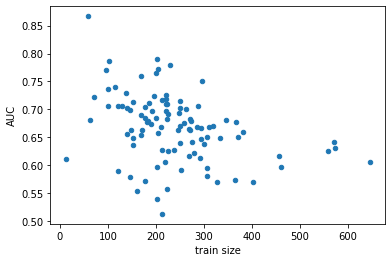

In [8]:
res_knn.plot(x='train size', y='AUC', kind='scatter')

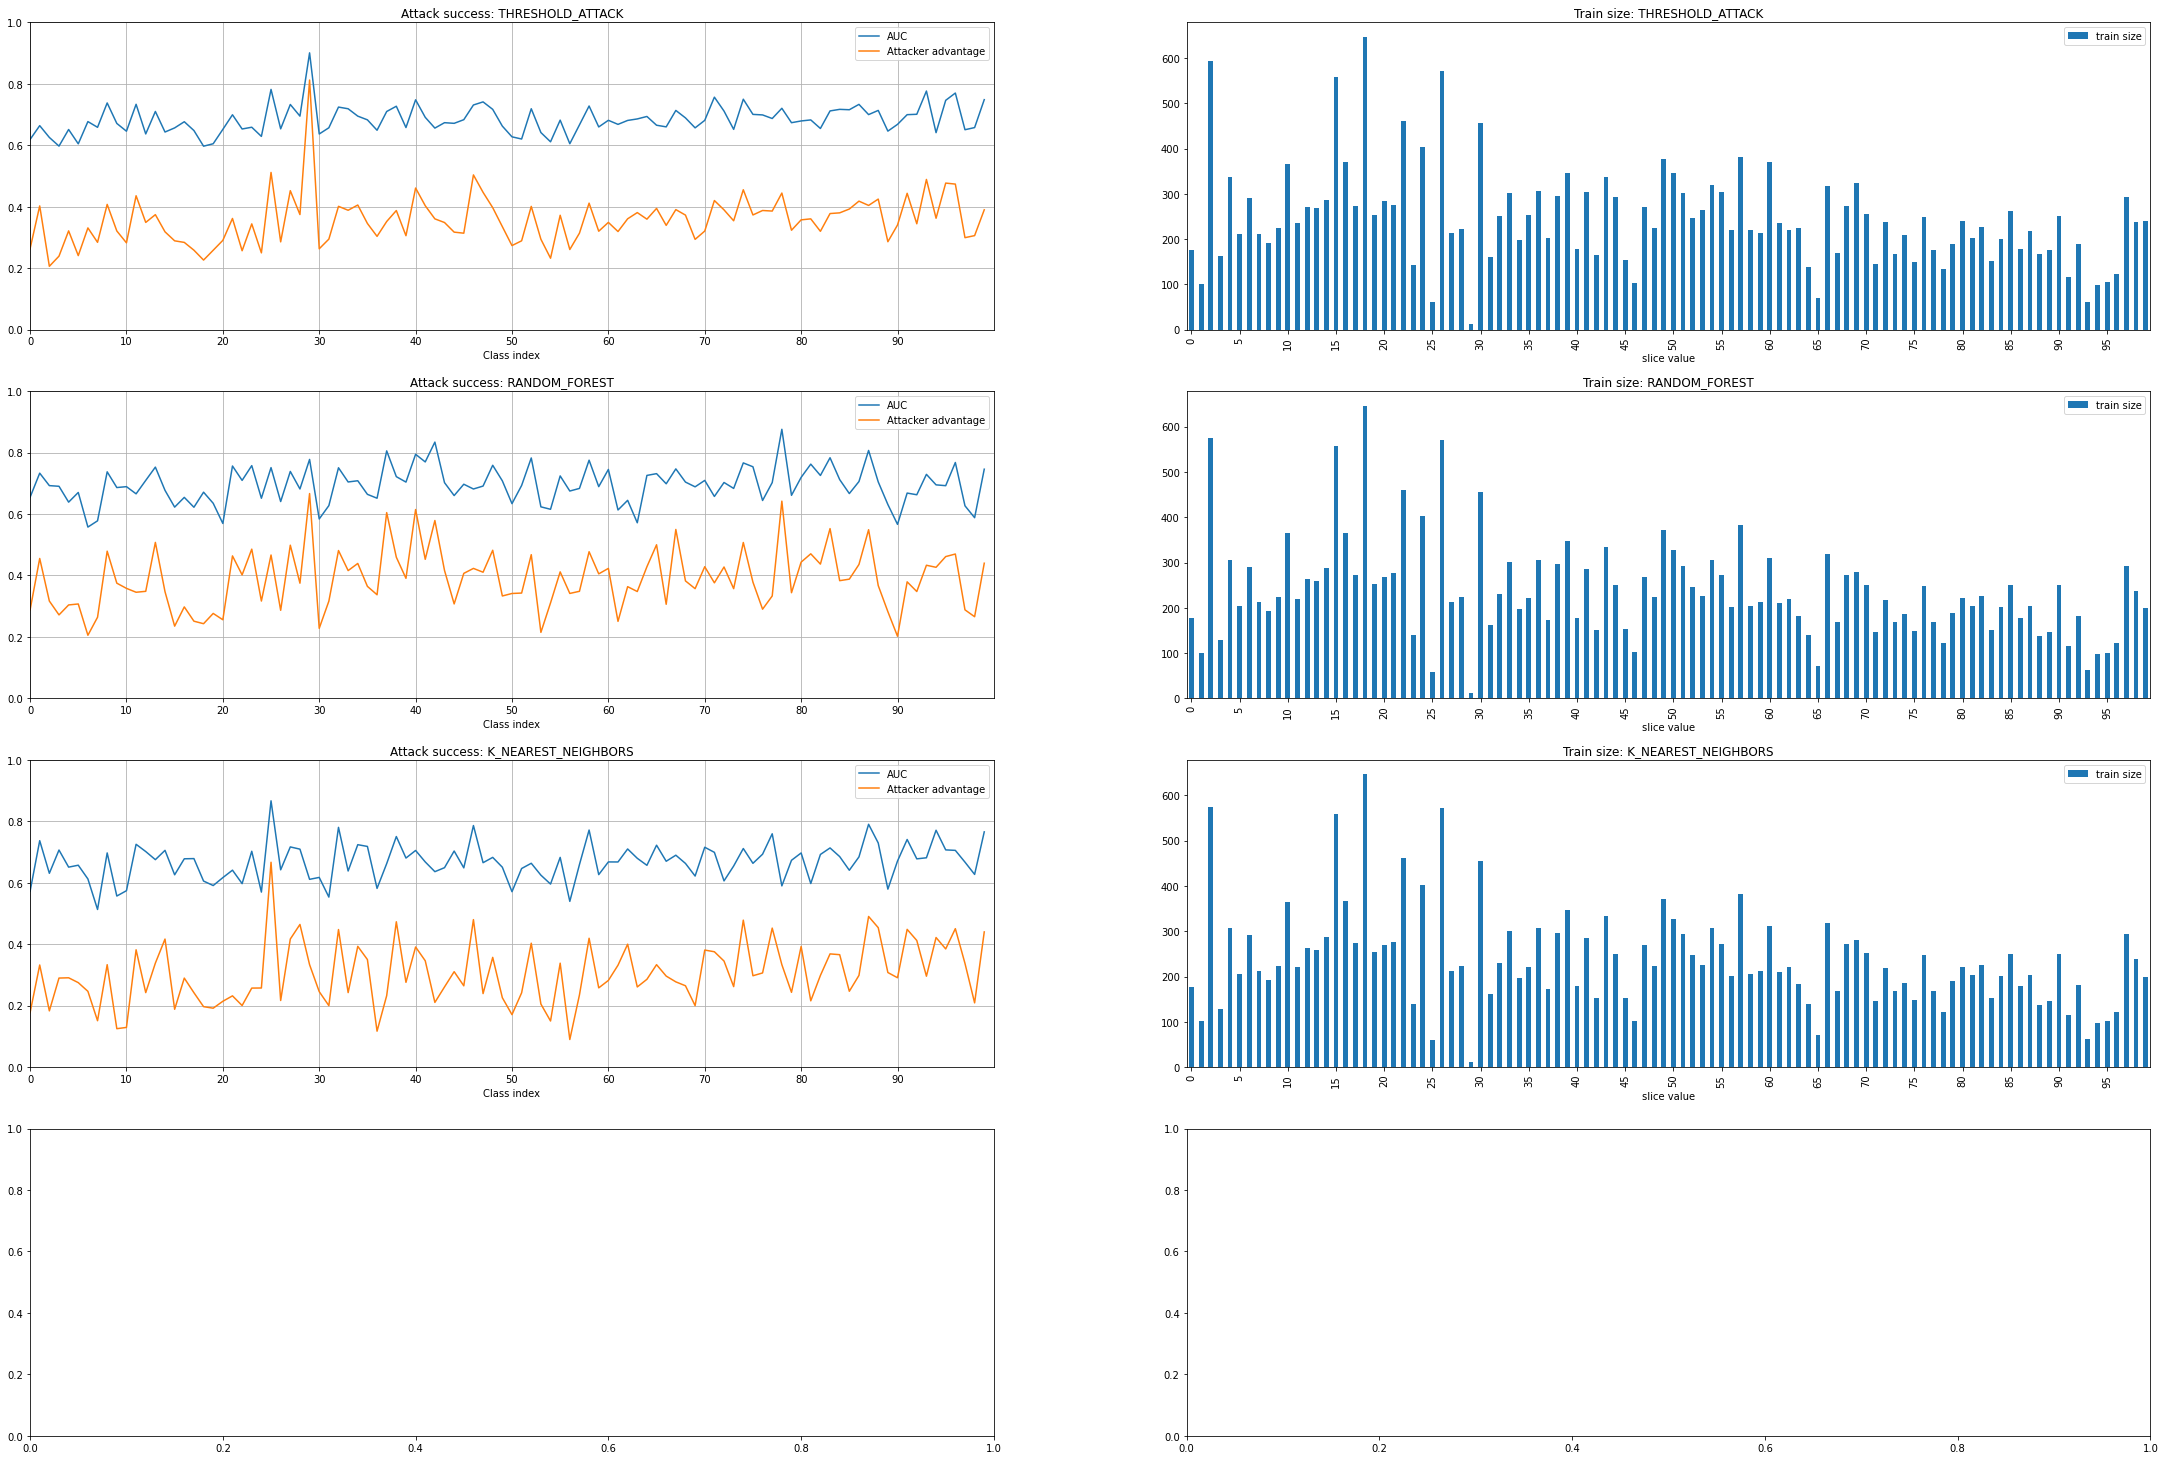

In [9]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(38,26))

for i, atk_type in enumerate(attack_types):
    res = res_df.loc[res_df['attack type'] == str(atk_type)]
    res.plot(
        x="slice value",
        y=["AUC", "Attacker advantage"],
        xlim=(0,100),
        ylim=(0,1),
        grid=True,
        xticks=range(0,100,10),
        xlabel="Class index",
        title="Attack success: " + str(atk_type),
        ax=axes[i, 0]
    )
    
    res.plot(
        x="slice value",
        y=["train size"],
        kind="bar",
        xlim=(0,100),
        #grid=True,
        xticks=range(0,100,5),
        #xlabel="Class index",
        title="Train size: " + str(atk_type),
        ax=axes[i, 1]
    )

In [13]:
(x_train, y_train), (x_test, y_test), (x_shadow, y_shadow) = experiments.data_utils.load_purchase100(shadow_size=0.75)

./datasets/dataset_purchase


In [19]:
from tensorflow.keras.utils import to_categorical

model_weights_path="./trained_models/purchase100-weights-best-50-epochs.hdf5"
model = model_purchase100()
model.summary()

predicted = to_categorical(np.argmax(model.predict(x_test), axis=1), 100)
report = classification_report(y_test, predicted)

try:
    model.load_weights(model_weights_path)
    print("Loaded model weights successfully from file ", model_weights_path)
except:
    print("Unable to load model")

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, 1024)              615424    
                                                                 
 layer2 (Dense)              (None, 512)               524800    
                                                                 
 layer3 (Dense)              (None, 256)               131328    
                                                                 
 layer4 (Dense)              (None, 128)               32896     
                                                                 
 layer5 (Dense)              (None, 100)               12900     
                                                                 
Total params: 1,317,348
Trainable params: 1,317,348
Non-trainable params: 0
_________________________________________________________________
Loaded model weights successfully from file 

/home/enoch/g/diplomski/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [12]:
probs_train = model.predict(x_train)
probs_test = model.predict(x_test)
labels_train = np.argmax(y_train, axis=1)
labels_test = np.argmax(y_test, axis=1)

membership_probability_results = nbfuns.calculate_membership_probabilities(probs_train, probs_test, labels_train, labels_test)
threshold_list = [1, 0.9, 0.8, 0.7, 0.6, 0.5]
print(membership_probability_results.summary(threshold_list=threshold_list))


Membership probability analysis over slice: "Entire dataset"
  with 0.6000 as the threshold on membership probability, the precision-recall pair is (0.6147, 0.6135)
  with 0.5000 as the threshold on membership probability, the precision-recall pair is (0.6040, 0.8596)
  thresholding on membership probability achieved an AUC of 0.67
  thresholding on membership probability achieved an advantage of 0.30

Membership probability analysis over slice: "CLASS=0"
  with 0.7000 as the threshold on membership probability, the precision-recall pair is (0.7360, 0.1356)
  with 0.6000 as the threshold on membership probability, the precision-recall pair is (0.6694, 0.3503)
  with 0.5000 as the threshold on membership probability, the precision-recall pair is (0.6141, 0.7740)
  thresholding on membership probability achieved an AUC of 0.68
  thresholding on membership probability achieved an advantage of 0.29

Membership probability analysis over slice: "CLASS=1"
  with 0.7000 as the threshold on me

In [20]:
#for member_probas in membership_probability_results.membership_prob_results:
#    results = member_probas.collect_results([0.5], return_roc_results=True)
#    print(results)

n_classes = 3
sorted_results = res_ta.sort_values(by="AUC")
least_vulnerable = sorted_results[:n_classes]
most_vulnerable = sorted_results[len(sorted_results) - n_classes:]
least_vulnerable

print(y_train.shape)

(24665, 100)


In [21]:
def extract_inputs_using_dataframe_to_empty_ndarray(x_train, y_train, df):
    ys = np.array([], dtype=np.int64).reshape(0,100)
    xs = np.array([], dtype=np.int64).reshape(0,600)
    
    for c in df["slice value"]:
        indices = np.where(np.argmax(y_train, axis=1) == int(c))
        xs_new = x_train[indices]
        ys_new = y_train[indices]
        xs = np.vstack([xs, xs_new])
        ys = np.vstack([ys, ys_new])

    return xs, ys

In [22]:
xs_lowest, ys_lowest = extract_inputs_using_dataframe_to_empty_ndarray(x_train, y_train, least_vulnerable)
xs_highest, ys_highest = extract_inputs_using_dataframe_to_empty_ndarray(x_train, y_train, most_vulnerable)
xs_final = np.vstack([xs_lowest, xs_highest])
ys_final = np.vstack([ys_lowest, ys_highest])
ys_final = np.argmax(ys_final, axis=1)

xs_lowest_test, ys_lowest_test = extract_inputs_using_dataframe_to_empty_ndarray(x_test, y_test, least_vulnerable)
xs_highest_test, ys_highest_test = extract_inputs_using_dataframe_to_empty_ndarray(x_test, y_test, most_vulnerable)
xs_final_test = np.vstack([xs_lowest_test, xs_highest_test])
ys_final_test = np.vstack([ys_lowest_test, ys_highest_test])
ys_final_test = np.argmax(ys_final_test, axis=1)

print(ys_final)

[18 18 18 ... 29 29 29]


Samples with highest membership risk in class 3


/home/enoch/g/diplomski/env/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/enoch/g/diplomski/env/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1166 samples in 0.000s...
[t-SNE] Computed neighbors for 1166 samples in 0.072s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1166
[t-SNE] Computed conditional probabilities for sample 1166 / 1166
[t-SNE] Mean sigma: 5.437395
[t-SNE] KL divergence after 250 iterations with early exaggeration: 87.095970
[t-SNE] KL divergence after 1000 iterations: 1.743967
t-SNE done! Time elapsed: 3.7375853061676025 seconds


/home/enoch/g/diplomski/env/lib/python3.8/site-packages/seaborn/_core.py:882: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  val in data


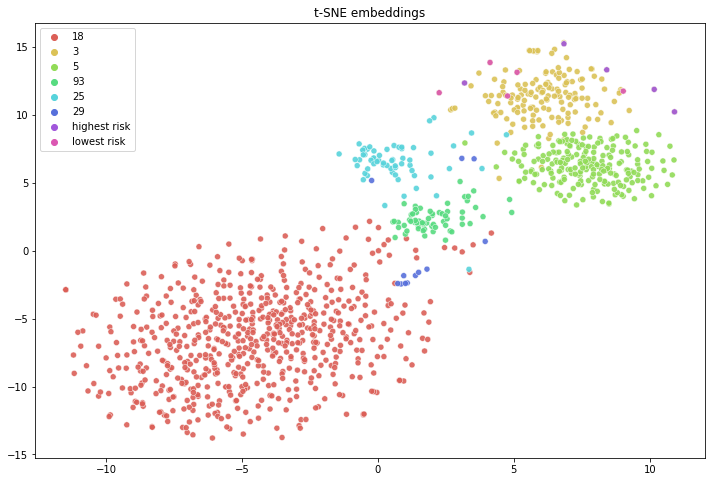

Samples with highest membership risk in class 5


/home/enoch/g/diplomski/env/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/enoch/g/diplomski/env/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1166 samples in 0.001s...
[t-SNE] Computed neighbors for 1166 samples in 0.092s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1166
[t-SNE] Computed conditional probabilities for sample 1166 / 1166
[t-SNE] Mean sigma: 5.426913
[t-SNE] KL divergence after 250 iterations with early exaggeration: 87.077095
[t-SNE] KL divergence after 1000 iterations: 1.751817
t-SNE done! Time elapsed: 3.7379252910614014 seconds


/home/enoch/g/diplomski/env/lib/python3.8/site-packages/seaborn/_core.py:882: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  val in data


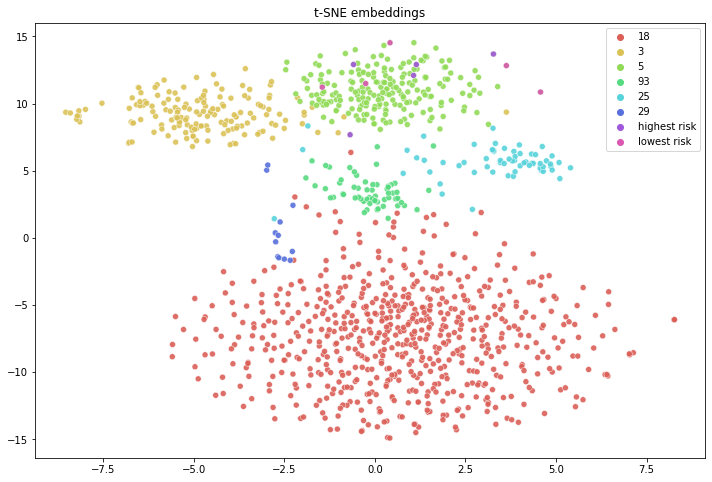

Samples with highest membership risk in class 18


/home/enoch/g/diplomski/env/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/enoch/g/diplomski/env/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1166 samples in 0.000s...
[t-SNE] Computed neighbors for 1166 samples in 0.081s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1166
[t-SNE] Computed conditional probabilities for sample 1166 / 1166
[t-SNE] Mean sigma: 5.436972
[t-SNE] KL divergence after 250 iterations with early exaggeration: 83.549644
[t-SNE] KL divergence after 1000 iterations: 1.740197
t-SNE done! Time elapsed: 3.5402495861053467 seconds


/home/enoch/g/diplomski/env/lib/python3.8/site-packages/seaborn/_core.py:882: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  val in data


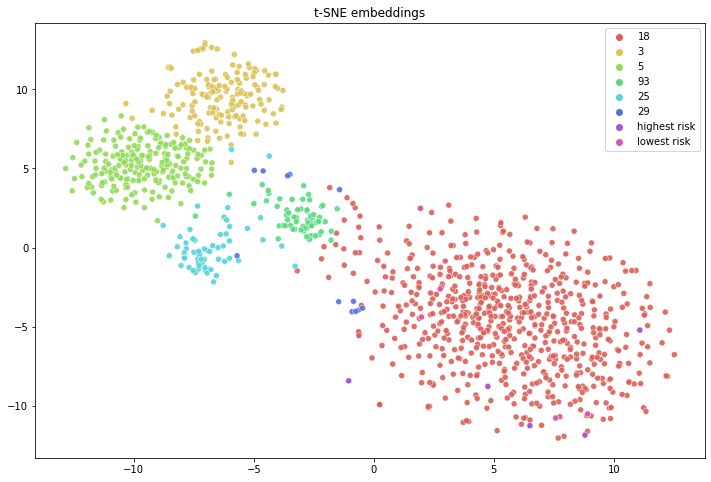

Samples with highest membership risk in class 25


/home/enoch/g/diplomski/env/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/enoch/g/diplomski/env/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1166 samples in 0.000s...
[t-SNE] Computed neighbors for 1166 samples in 0.093s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1166
[t-SNE] Computed conditional probabilities for sample 1166 / 1166
[t-SNE] Mean sigma: 5.437954
[t-SNE] KL divergence after 250 iterations with early exaggeration: 85.807205
[t-SNE] KL divergence after 1000 iterations: 1.740180
t-SNE done! Time elapsed: 3.582569122314453 seconds


/home/enoch/g/diplomski/env/lib/python3.8/site-packages/seaborn/_core.py:882: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  val in data


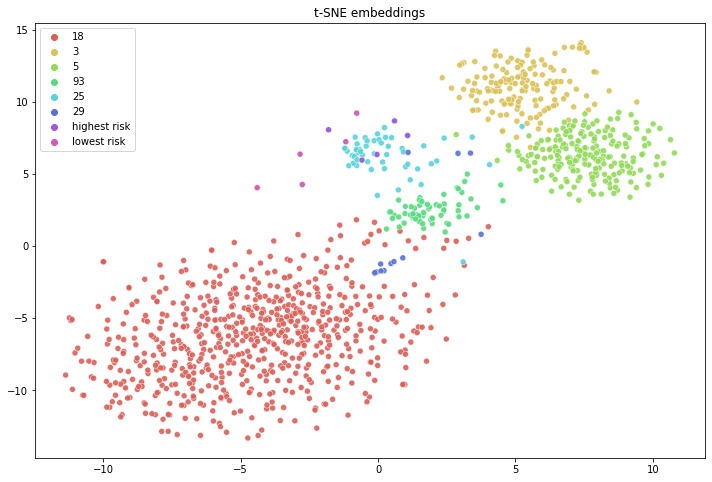

Samples with highest membership risk in class 29
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1166 samples in 0.000s...


/home/enoch/g/diplomski/env/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/enoch/g/diplomski/env/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computed neighbors for 1166 samples in 0.065s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1166
[t-SNE] Computed conditional probabilities for sample 1166 / 1166
[t-SNE] Mean sigma: 5.436737
[t-SNE] KL divergence after 250 iterations with early exaggeration: 87.495079
[t-SNE] KL divergence after 1000 iterations: 1.745575
t-SNE done! Time elapsed: 3.8952138423919678 seconds


/home/enoch/g/diplomski/env/lib/python3.8/site-packages/seaborn/_core.py:882: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  val in data


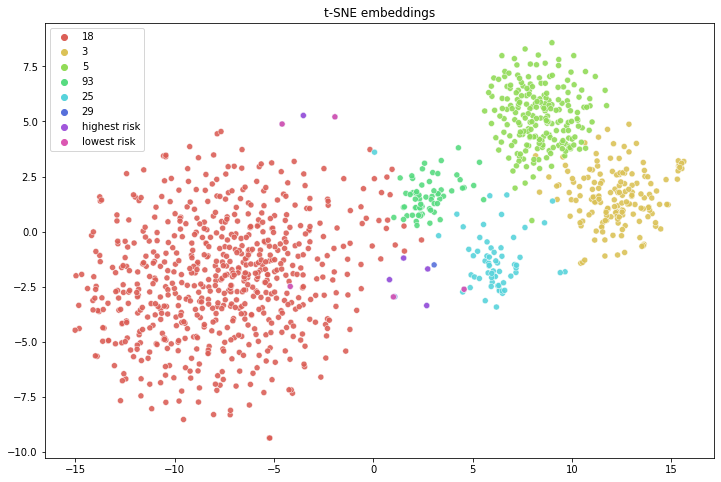

Samples with highest membership risk in class 93


/home/enoch/g/diplomski/env/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/enoch/g/diplomski/env/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1166 samples in 0.000s...
[t-SNE] Computed neighbors for 1166 samples in 0.084s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1166
[t-SNE] Computed conditional probabilities for sample 1166 / 1166
[t-SNE] Mean sigma: 5.440593
[t-SNE] KL divergence after 250 iterations with early exaggeration: 86.214645
[t-SNE] KL divergence after 1000 iterations: 1.746690
t-SNE done! Time elapsed: 3.8164024353027344 seconds


/home/enoch/g/diplomski/env/lib/python3.8/site-packages/seaborn/_core.py:882: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  val in data


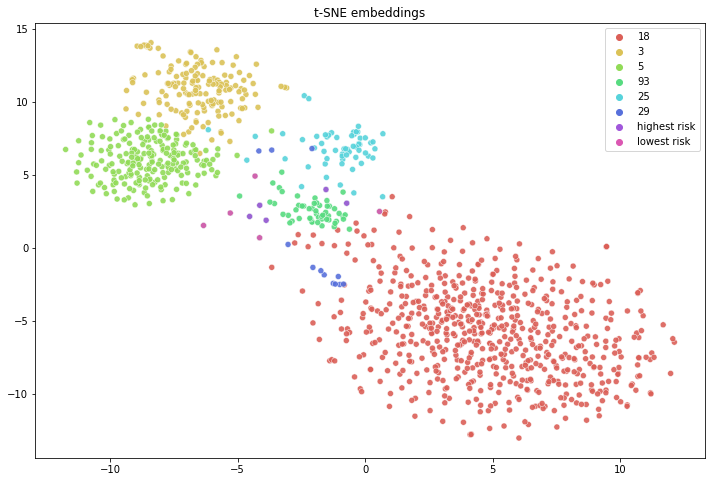

In [23]:
importlib.reload(nbfuns)
nbfuns.plot_membership_probabilities(
    model.predict(xs_final),
    model.predict(xs_final_test),
    ys_final,
    ys_final_test,
    xs_final,
    ys_final,
    num_samples=5,
    use_tsne=True
)

Samples with highest membership risk in class 3


/home/enoch/g/diplomski/env/lib/python3.8/site-packages/seaborn/_core.py:882: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  val in data


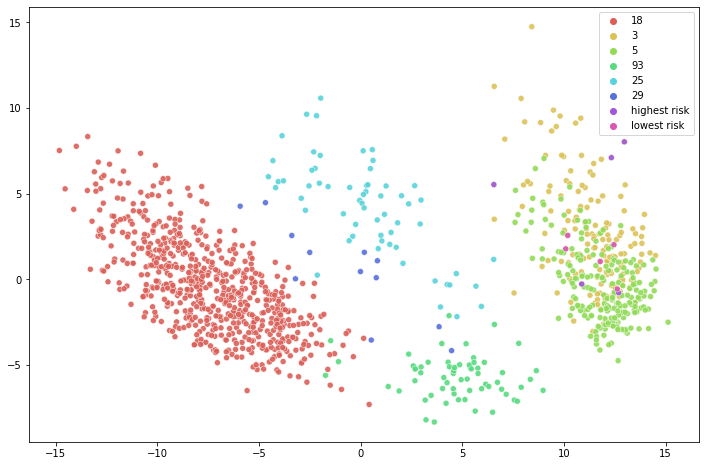

Samples with highest membership risk in class 5


/home/enoch/g/diplomski/env/lib/python3.8/site-packages/seaborn/_core.py:882: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  val in data


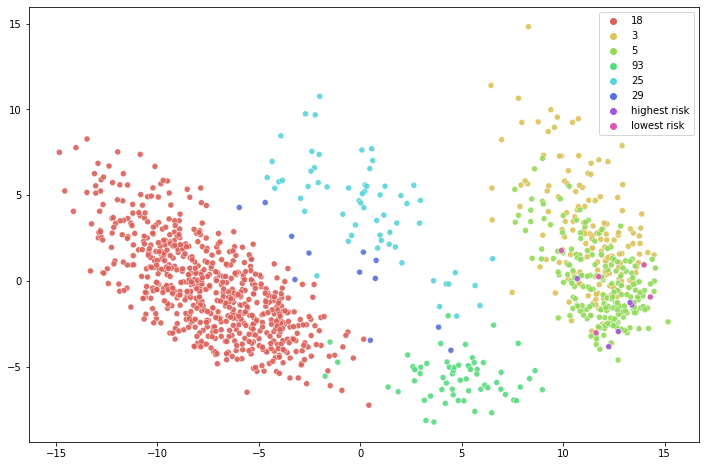

Samples with highest membership risk in class 18


/home/enoch/g/diplomski/env/lib/python3.8/site-packages/seaborn/_core.py:882: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  val in data


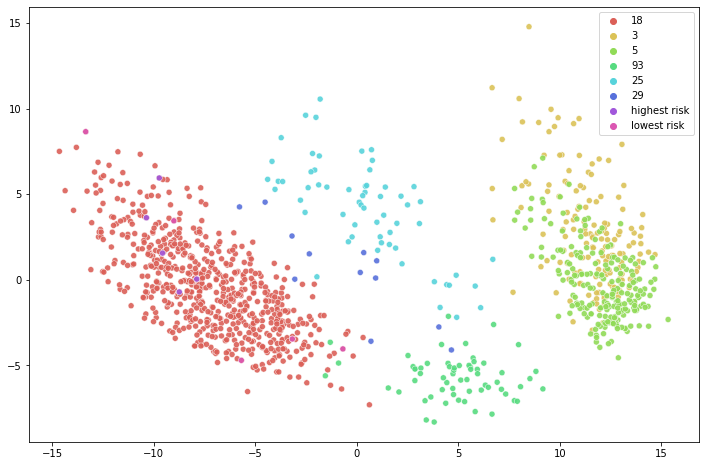

Samples with highest membership risk in class 25


/home/enoch/g/diplomski/env/lib/python3.8/site-packages/seaborn/_core.py:882: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  val in data


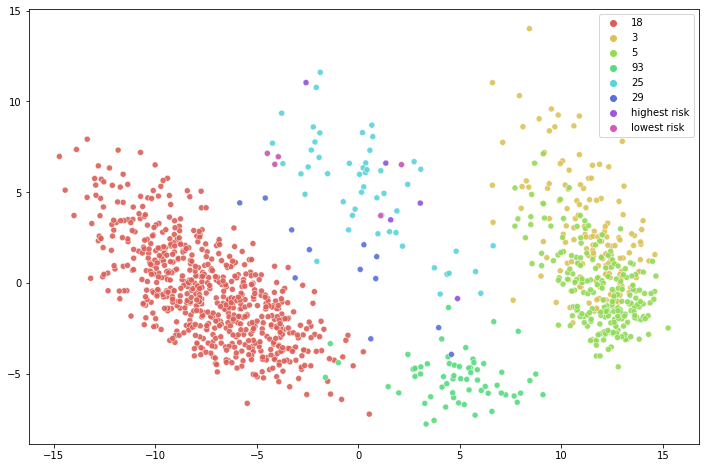

Samples with highest membership risk in class 29


/home/enoch/g/diplomski/env/lib/python3.8/site-packages/seaborn/_core.py:882: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  val in data


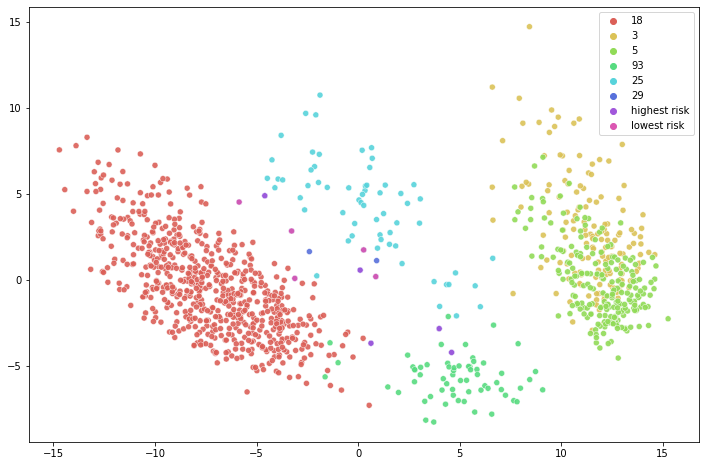

Samples with highest membership risk in class 93


/home/enoch/g/diplomski/env/lib/python3.8/site-packages/seaborn/_core.py:882: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  val in data


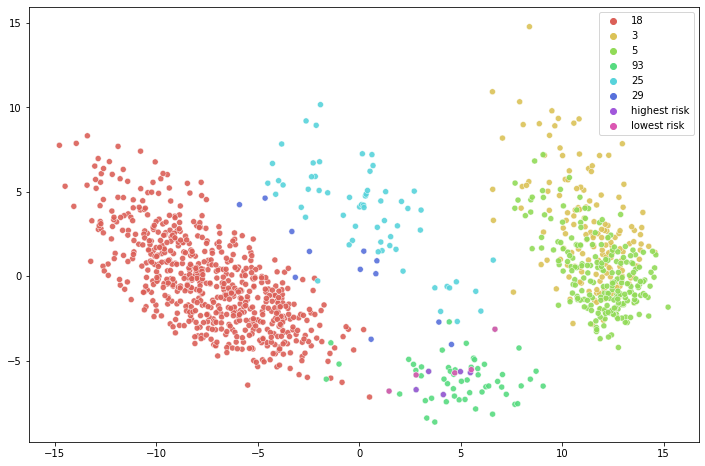

In [24]:
nbfuns.plot_membership_probabilities(
    model.predict(xs_final),
    model.predict(xs_final_test),
    ys_final,
    ys_final_test,
    xs_final,
    ys_final,
    num_samples=5,
    use_tsne=False
)